In [2]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
# import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
warnings.filterwarnings("ignore")




/homes/metogra/iufarias/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [3]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

# Reading CROCO files

In [4]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [14]:
client = Client(n_workers=90)
# client = Client(cluster)

In [6]:
client

<Client: 'tcp://127.0.0.1:40923' processes=90 threads=180, memory=503.40 GiB>

## Reading CROCO (3D)

In [7]:
# chunks={'time_counter':10, 'x_rho':50, 'y_rho':190,'s_rho':80,'s_w':80}
chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
                        'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}


path='/data/pacific/lrenault/SASI/CROCO/'

# varf=xr.open_mfdataset(path + 'FULL/SASI*2012-01*.nc',data_vars='minimal',chunks=chunks)
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-01*.nc',data_vars='minimal',chunks=chunks)

varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)



In [8]:
if varf.time_counter.shape[0]>150:
    month='total'
else:
    month='{0:02d}'.format(pd.DatetimeIndex(varf.time_counter)[0].month)
print(month)

total


Converting to xroms

In [9]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

In [10]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [11]:
timer_h=pd.DatetimeIndex(dt.ocean_time)
timer_d=pd.DatetimeIndex(dt.ocean_time.groupby("ocean_time.dayofyear").mean())

#### Spectral parameters

In [12]:
z_interp=np.linspace(-5,-50, 10)
fnum=240

In [13]:
import warnings

warnings.filterwarnings("ignore")

# Averaging Velocities

## FULL 

In [42]:
u_full_psi=df.u.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800]
v_full_psi=df.v.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800]



In [43]:
u_meanz_full=xr.DataArray(coords=(u_full_psi.ocean_time,
                             (df.u.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800].eta_v),
                            (df.u.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800].xi_u)),
            dims=['ocean_time','eta_v','xi_u'])
v_meanz_full=xr.DataArray(coords=(v_full_psi.ocean_time,
                             (df.v.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800].eta_v),
                            (df.v.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800].xi_u)),
            dims=['ocean_time','eta_v','xi_u'])

In [44]:
%%time
for ix in range(u_full_psi.shape[0]):
    
    u_interp_full=u_full_psi[ix].xroms.isoslice(z_interp).compute()
    v_interp_full=v_full_psi[ix].xroms.isoslice(z_interp).compute()
    
    u_meanz_full[ix,:,:]=u_interp_full.mean(axis=0)
    v_meanz_full[ix,:,:]=v_interp_full.mean(axis=0)



CPU times: user 44min 8s, sys: 15min 26s, total: 59min 34s
Wall time: 2h 29min 35s


In [45]:
gc.collect()
# u_meanz_full.to_netcdf('/homes/metogra/iufarias/Documents/data/histograms_3d/u_full_{0}.nc'.format(month))
# v_meanz_full.to_netcdf('/homes/metogra/iufarias/Documents/data/histograms_3d/v_full_{0}.nc'.format(month))

985

## 'SMTH'

In [46]:
u_smth_psi=dt.u.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800]
v_smth_psi=dt.v.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800]

In [47]:
u_meanz_smth=xr.DataArray(coords=(u_smth_psi.ocean_time,
                             (dt.u.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800].eta_v),
                            (dt.u.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800].xi_u)),
            dims=['ocean_time','eta_v','xi_u'])
v_meanz_smth=xr.DataArray(coords=(v_smth_psi.ocean_time,
                             (dt.v.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800].eta_v),
                            (dt.v.xroms.to_grid('psi', 's_rho')[:,:,120:-120,120:800].xi_u)),
            dims=['ocean_time','eta_v','xi_u'])

In [48]:
%%time
for ix in range(u_smth_psi.shape[0]):
    
    u_interp_smth=u_smth_psi[ix].xroms.isoslice(z_interp).compute()
    v_interp_smth=v_smth_psi[ix].xroms.isoslice(z_interp).compute()
    
    u_meanz_smth[ix,:,:]=u_interp_smth.mean(axis=0)
    v_meanz_smth[ix,:,:]=v_interp_smth.mean(axis=0)



CPU times: user 44min 23s, sys: 15min 20s, total: 59min 43s
Wall time: 2h 28min 10s


In [49]:
gc.collect()
# u_meanz_smth.to_netcdf('/homes/metogra/iufarias/Documents/data/histograms_3d/u_smth_{0}.nc'.format(month))
# v_meanz_smth.to_netcdf('/homes/metogra/iufarias/Documents/data/histograms_3d/v_smth_{0}.nc'.format(month))

9737

# Averaging buoyancy

In [50]:
rho_full=dt.rho
rho_smth=df.rho


rho_interp_full=rho_full[:,:,120:-120,120:800]
rho_interp_smth=rho_smth[:,:,120:-120,120:800]

In [51]:
%time
b_meanz_full=xr.DataArray(coords=(rho_interp_full.ocean_time,
                             (df.rho[:,:,120:-120,120:800].eta_rho),
                            (df.rho[:,:,120:-120,120:800].xi_rho)),
            dims=['ocean_time','eta_v','xi_u'])
b_meanz_smth=xr.DataArray(coords=(rho_interp_smth.ocean_time,
                             (dt.rho[:,:,120:-120,120:800].eta_rho),
                            (dt.rho[:,:,120:-120,120:800].xi_rho)),
            dims=['ocean_time','eta_v','xi_u'])

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 18.1 µs


In [52]:
%%time
for ix in range(u_smth_psi.shape[0]):
    rho_interp_full_d=rho_interp_full[ix].xroms.isoslice(z_interp).compute()
    b_interp_full=xroms.buoyancy(rho_interp_full_d)
    
    rho_interp_smth_d=rho_interp_smth[ix].xroms.isoslice(z_interp).compute()
    b_interp_smth=xroms.buoyancy(rho_interp_smth_d)
    
    
    b_meanz_full[ix]=b_interp_full.mean(axis=0)
    b_meanz_smth[ix]=b_interp_smth.mean(axis=0)
    

CPU times: user 47min 35s, sys: 16min 18s, total: 1h 3min 53s
Wall time: 2h 31min 40s


# Derivatives

In [53]:
dx=500

In [54]:
zeta_f=np.gradient(v_meanz_full,axis=2)/dx -np.gradient(u_meanz_full,axis=1)/dx
zeta_t=np.gradient(v_meanz_smth,axis=2)/dx -np.gradient(u_meanz_smth,axis=1)/dx

In [55]:
div_f=np.gradient(u_meanz_full,axis=2)/dx +np.gradient(v_meanz_full,axis=1)/dx
div_t=np.gradient(u_meanz_smth,axis=2)/dx +np.gradient(v_meanz_smth,axis=1)/dx

In [56]:
import seawater as sw
f=sw.f(rho_interp_full.nav_lat_rho[1:-1,:]).mean()

In [57]:
bx_f=(np.gradient(b_meanz_full[:,1:-1,:],axis=2)/dx)
by_f=(np.gradient(b_meanz_full[:,1:-1,:],axis=1)/dx)

bx_t=(np.gradient(b_meanz_smth[:,1:-1,:],axis=2)/dx)
by_t=(np.gradient(b_meanz_smth[:,1:-1,:],axis=1)/dx)

In [58]:
bM_f=np.sqrt(bx_f**2+by_f**2)
bM_t=np.sqrt(bx_t**2+by_t**2)

In [59]:
bM_full_norm=(bM_f/((f**2)))
bM_smth_norm=(bM_t/((f**2)))

# Statistics

In [60]:
# val_b=0
# mask_full=[bM_full_norm>=val_b][0]
# mask_smth=[bM_smth_norm>=val_b][0]

In [61]:
mean_f_z,med_f_z,std_f_z=np.nanmean((zeta_f/f)),np.nanmedian((zeta_f/f)),np.nanstd((zeta_f/f))
mean_t_z,med_t_z,std_t_z=np.nanmean((zeta_t/f)),np.nanmedian((zeta_t/f)),np.nanstd((zeta_t/f))

mean_f_div,med_f_div,std_f_div=np.nanmean((div_f/f)),np.nanmedian((div_f/f)),np.nanstd((div_f/f))
mean_t_div,med_t_div,std_t_div=np.nanmean((div_t/f)),np.nanmedian((div_t/f)),np.nanstd((div_t/f))

mean_f_gb,med_f_gb,std_f_gb=np.nanmean((bM_f/f**2)),np.nanmedian((bM_f/f**2)),np.nanstd((bM_f/f**2))
mean_t_gb,med_t_gb,std_t_gb=np.nanmean((bM_t/f**2)),np.nanmedian((bM_t/f**2)),np.nanstd((bM_t/f**2))


# Plots

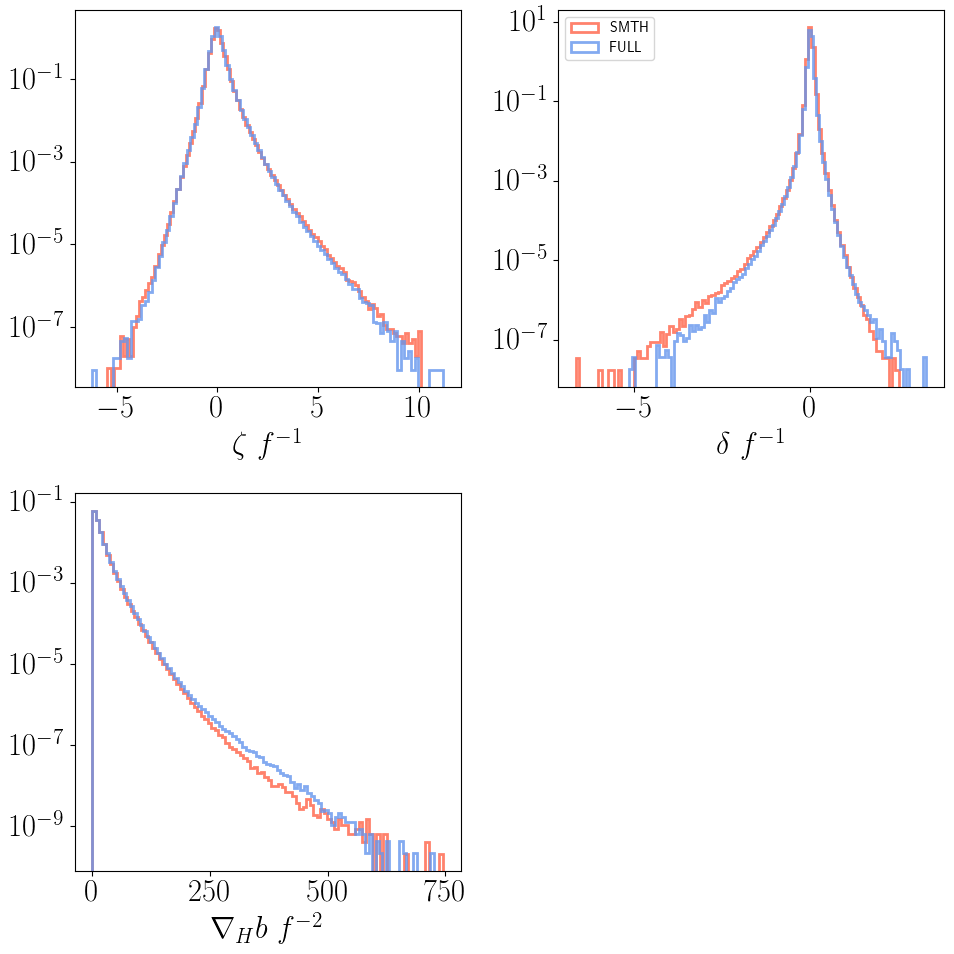

In [62]:
dbool=True
slog=True

a1=0.8
a2=0.8
lw=2
HT='step'

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(np.ravel((zeta_t/f)),bins=100,color='tomato',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(np.ravel((zeta_f/f)),bins=100,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,density=dbool,log=slog)

# plt.text(3.1,0.4,r' $\mu$' + '={0:.1e} \n'.format(mean_f_z)+ r'M' + '={0:.1e} \n'.format(med_f_z) + r'$\sigma$'+'={0:.1e}'.format(std_f_z),color='cornflowerblue',fontsize=12)
# plt.text(3.1,0.2,r' $\mu$' + '={0:.1e} \n'.format(mean_t_z)+ r'M' + '={0:.1e} \n'.format(med_t_z) + r'$\sigma$'+'={0:.1e}'.format(std_t_z),color='tomato',fontsize=12) 
# plt.text(10,0.12,r' $\mu$' + '={0:.1e} \n'.format(mean_f_z)+ r'M' + '={0:.1e} \n'.format(med_f_z) + r'$\sigma$'+'={0:.1e}'.format(std_f_z),color='cornflowerblue',fontsize=12)
# plt.text(10,0.04,r' $\mu$' + '={0:.1e} \n'.format(mean_t_z)+ r'M' + '={0:.1e} \n'.format(med_t_z) + r'$\sigma$'+'={0:.1e}'.format(std_t_z),color='tomato',fontsize=12) 

# plt.xlim(-2,2)
plt.xlabel(r'$\zeta$ $f^{-1}$')


plt.subplot(2,2,2)
plt.hist(np.ravel((div_t/f)),bins=100,color='tomato',linewidth=lw,histtype=HT,alpha=a2,label='SMTH',density=dbool,log=slog)
plt.hist(np.ravel((div_f/f)),bins=100,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,label='FULL',density=dbool,log=slog)
plt.legend(fontsize=10,loc=2)



# plt.text(-10,0.3,r' $\mu$' + '={0:.1e} \n'.format(mean_f_div)+ r'M' + '={0:.1e} \n'.format(med_f_div) + r'$\sigma$'+'={0:.1e}'.format(std_f_div),color='cornflowerblue',fontsize=12)
# plt.text(-10,0.1,r' $\mu$' + '={0:.1e} \n'.format(mean_t_div)+ r'M' + '={0:.1e} \n'.format(med_t_div) + r'$\sigma$'+'={0:.1e}'.format(std_t_div),color='tomato',fontsize=12) 
# # plt.text(1.2,0.8,r' $\mu$' + '={0:.1e} \n'.format(mean_f_div)+ r'M' + '={0:.1e} \n'.format(med_f_div) + r'$\sigma$'+'={0:.1e}'.format(std_f_div),color='cornflowerblue',fontsize=12)
# # plt.text(1.2,0.4,r' $\mu$' + '={0:.1e} \n'.format(mean_t_div)+ r'M' + '={0:.1e} \n'.format(med_t_div) + r'$\sigma$'+'={0:.1e}'.format(std_t_div),color='tomato',fontsize=12) 


# plt.xlim(-1,1)
plt.xlabel(r'$\delta$ $f^{-1}$')


plt.subplot(2,2,3)
plt.hist(np.ravel(bM_smth_norm),bins=100,color='tomato',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(np.ravel(bM_full_norm),bins=100,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,density=dbool,log=slog)

# plt.text(1000,0.006,r' $\mu$' + '={0:.1f} \n'.format(mean_f_gb)+ r'M' + '={0:.1f} \n'.format(med_f_gb) + r'$\sigma$'+'={0:.1f}'.format(std_f_gb),color='cornflowerblue',fontsize=12)
# plt.text(1000,0.002,r' $\mu$' + '={0:.1f} \n'.format(mean_t_gb)+ r'M' + '={0:.1f} \n'.format(med_t_gb) + r'$\sigma$'+'={0:.1f}'.format(std_t_gb),color='tomato',fontsize=12) 
# # plt.text(200,0.016,r' $\mu$' + '={0:.1f} \n'.format(mean_f_gb)+ r'M' + '={0:.1f} \n'.format(med_f_gb) + r'$\sigma$'+'={0:.1f}'.format(std_f_gb),color='cornflowerblue',fontsize=12)
# # plt.text(200,0.008,r' $\mu$' + '={0:.1f} \n'.format(mean_t_gb)+ r'M' + '={0:.1f} \n'.format(med_t_gb) + r'$\sigma$'+'={0:.1f}'.format(std_t_gb),color='tomato',fontsize=12) 


# plt.xlim(0,100)
# plt.xlim(450,1250)
# # plt.xlim(100,1250)




plt.xlabel(r'$\nabla_H b$ $f^{-2}$')




plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/z_MEAN_histograms_assessment_log={0}.png'.format(slog))
# # plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histograms_assessment_high_buoyancy_log.png')




# Upwelling Index

In [29]:
t_full=dt.temp[:,:,:,800:900][::5]
t_smth=df.temp[:,:,:,800:900][::5]

In [30]:
%time
t_up_full=xr.DataArray(coords=(t_full.ocean_time,
                             (df.rho[:,:,:,800:900].eta_rho),
                            (df.rho[:,:,:,800:900].xi_rho)),
            dims=['ocean_time','eta_v','xi_u'])
t_up_smth=xr.DataArray(coords=(t_smth.ocean_time,
                             (dt.rho[:,:,:,800:900].eta_rho),
                            (dt.rho[:,:,:,800:900].xi_rho)),
            dims=['ocean_time','eta_v','xi_u'])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


In [31]:
%%time
for ix in range(t_full.ocean_time.shape[0]):
    t_interp_full_d=t_full[ix].xroms.isoslice(z_interp).compute()    
    t_interp_smth_d=t_smth[ix].xroms.isoslice(z_interp).compute()
    
    
    t_up_full[ix]=t_interp_full_d.mean(axis=0)
    t_up_smth[ix]=t_interp_smth_d.mean(axis=0)

CPU times: user 5min 27s, sys: 1min 33s, total: 7min 1s
Wall time: 15min 45s


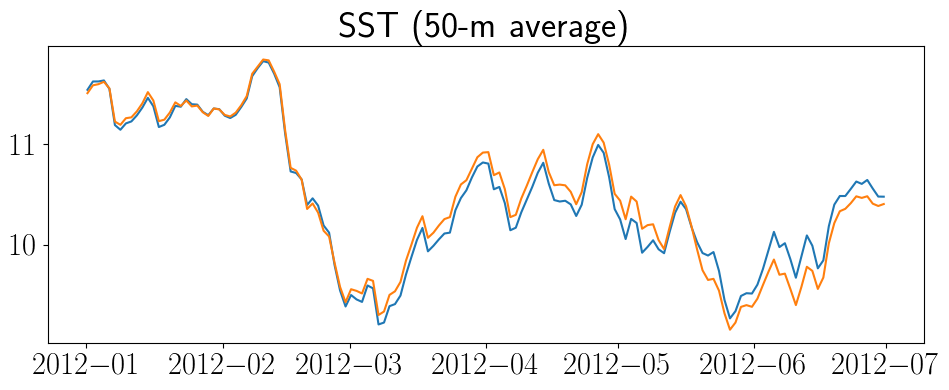

In [41]:
plt.figure(figsize=(10,4))
plt.plot(t_up_full.ocean_time,t_up_full.mean(['eta_v','xi_u']))
plt.plot(t_up_smth.ocean_time,t_up_smth.mean(['eta_v','xi_u']))
plt.tight_layout()
plt.title('SST (50-m average)')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/upwelling_index_50m.png')

